In [1]:
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow import keras
from keras.layers import Conv1D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, Activation, Dropout, Add
from keras import Sequential
from keras.layers import BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
import os
import numpy as np
import argparse
import pandas as pd
import math
import random as rd

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  classification_report, confusion_matrix


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


In [3]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive/Biomarketers
%pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kvysfPHz20qIMQi4u95yq6zZglZXtTs_/Biomarketers


'/content/drive/.shortcut-targets-by-id/1kvysfPHz20qIMQi4u95yq6zZglZXtTs_/Biomarketers'

#First datateset

In [29]:
# First dataset :
X_train = pd.read_csv("X_train_final_30.csv")
X_train = X_train.set_index(X_train.columns[0])
print(X_train.shape)
y_train = pd.read_csv("y_train_30.csv")
y_train = y_train.set_index(y_train.columns[0])
print(y_train.shape)
X_test = pd.read_csv("X_test_final_30.csv")
X_test = X_test.set_index(X_test.columns[0])
y_test = pd.read_csv("y_test_30.csv")
y_test = y_test.set_index(y_test.columns[0])
#y_test = y_test.drop(y_test.columns[0], axis =1)

y_train.columns
y_test.columns



(2625, 1533)
(2625, 1)


Index(['Activity'], dtype='object')

# Random Forest

In [6]:
#Create random forest classifier
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train.values.ravel())


RandomForestClassifier(n_estimators=150, random_state=42)

In [7]:
#Predict on test data
y_pred = clf.predict_proba(X_test)
y_pred_2 = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_2)
print(accuracy)

0.8152753108348135


In [65]:
y_pred_df = pd.DataFrame(y_pred, columns = ["0", "1"])
y_pred_df.to_csv("YPred_models/random_forest.csv")

In [ ]:
#Display the first 3 trees
for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

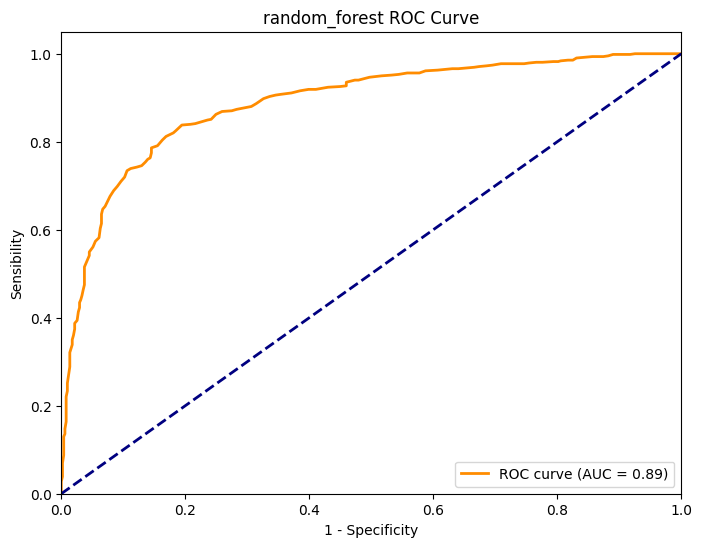

In [66]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_df["1"].values)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensibility')
plt.title('random_forest ROC Curve')
plt.legend(loc='lower right')
plt.savefig('Figures/random_forest_ROC.png',  dpi=500)
plt.show()

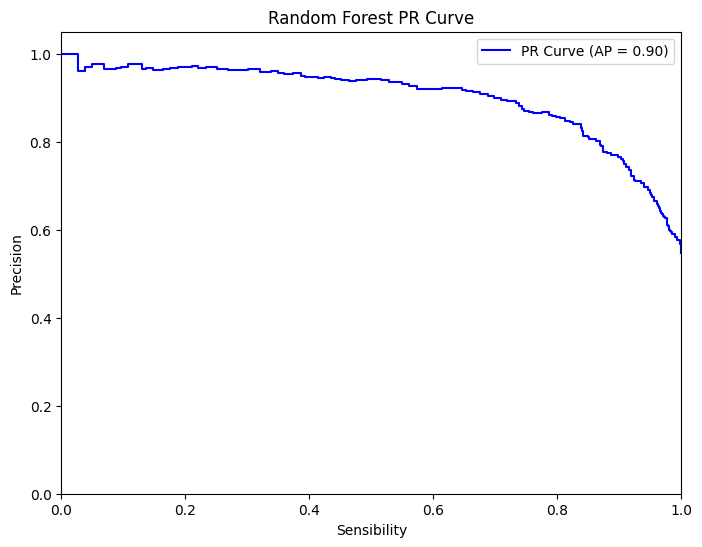

In [67]:
# PR curve :
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_df["1"].values)

average_precision = average_precision_score(y_test, y_pred_df["1"].values)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Sensibility')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Random Forest PR Curve')
plt.legend(loc='upper right')
plt.show()

[[399 110]
 [ 98 519]]
Accuracy:0.82


Text(45.722222222222214, 0.5, 'Obs')

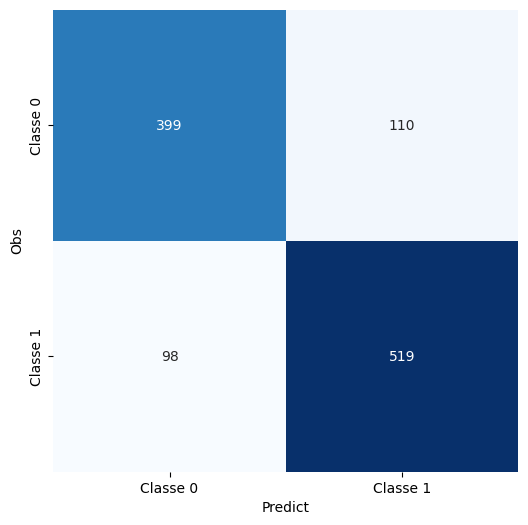

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_2)
print(cm)
tot = cm[0][0]+cm[1][1] + cm[0][1]+cm[1][0]
accuracy = (cm[0][0]+cm[1][1]) /tot
print(f"Accuracy:{accuracy:.2f}")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predict')
plt.ylabel('Obs')

In [70]:
# Calculate F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_2)
print("F1-Score:", f1)

# MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred_2)
print("MCC:", mcc)

# Sensibility :
from sklearn.metrics import recall_score
sensitivity = recall_score(y_test, y_pred_2)

print("Sensibilité", sensitivity)

# Calculate Specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Specificity:", specificity)

F1-Score: 0.8330658105939005
MCC: 0.6264948736938736
Sensibilité 0.8411669367909238
Specificity: 0.7838899803536346


### Soumission Kaggle

In [ ]:
kaggle_file = pd.read_csv("test.csv")
kaggle_file.head(5)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the data using Min-Max scaling


cols = X_train.columns

kaggle_file = kaggle_file[cols]
kaggle_file.shape

X_scaled = scaler.fit_transform(kaggle_file)
X_scaled = pd.DataFrame(X_scaled, columns = kaggle_file.columns)

ypred_kaggle_proba = clf.predict_proba(X_scaled)
y_pred_kaggle_df = pd.DataFrame(ypred_kaggle_proba, columns = ["0", "1"])
y_pred_kaggle_df['moleculeId']= y_pred_kaggle_df.index
y_pred_kaggle_df['moleculeId'] +=1
column_to_move = y_pred_kaggle_df.pop("moleculeId")
y_pred_kaggle_df.insert(0, "moleculeId", column_to_move)
y_pred_kaggle_df.pop("0")
y_pred_kaggle_df.columns = ["moleculeId","PredictedProbability"]
y_pred_kaggle_df.head(5)
y_pred_kaggle_df.to_csv("YPred_models/kaggle_random_forest.csv", index = False)

# Multi-Input Neural Network

In [4]:
#Read data
X_train = pd.read_csv("X_train_30.csv", index_col = 0)
print(X_train.shape)
y_train = pd.read_csv("y_train_30.csv", index_col = 0)
print(y_train.shape)
X_test = pd.read_csv("X_test_30.csv", index_col = 0)
y_test = pd.read_csv("y_test_30.csv", index_col = 0)
total = pd.read_csv("df_cleaned_39.csv", index_col = 0)


(2625, 1533)
(2625, 1)


In [5]:
#ID les variables catégoriques et continues
feature_cols = X_train.columns.tolist()

cnt_features = []
cat_features = []

for col in feature_cols:
    if X_train[col].dtype=='float64':
        cnt_features.append(col)
    else:
        cat_features.append(col)


X_train[cnt_features] = X_train[cnt_features].astype('float32')
X_train[cat_features] = X_train[cat_features].astype('uint8')
X_test[cnt_features] = X_test[cnt_features].astype('float32')
X_test[cat_features] = X_test[cat_features].astype('uint8')




In [6]:
bins = 128
n = 0
bins_list = []

bins_list.append(-np.inf)
for i in range(1,bins):
    n += 1./bins
    bins_list.append(n)
bins_list.append(np.inf)

labels = [i for i in range(bins)]
for col in cnt_features:
    X_train[col] = pd.cut(X_train[col], bins=bins_list, labels=labels)
    X_test[col] = pd.cut(X_test[col], bins=bins_list, labels=labels)

X_train.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
446,0,71,0,0,30,77,50,77,92,44,...,0,0,0,0,0,0,0,0,0,0
898,4,68,6,0,41,74,51,8,85,45,...,0,0,0,0,0,0,0,0,0,0
1516,21,99,19,0,31,67,54,45,76,55,...,0,0,0,0,0,0,0,0,0,0
1611,12,78,19,0,28,94,24,64,98,21,...,0,0,0,0,0,0,0,0,0,0
2751,4,57,0,0,16,79,48,73,94,42,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_train[cnt_features] = X_train[cnt_features].astype('uint8')
X_test[cnt_features] = X_test[cnt_features].astype('uint8')

In [8]:
X_train[cat_features]

,D23,D27,D28,D51,D94,D170,D568,D952,D953,D954,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
446,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1516,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1611,1,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2751,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1667,1,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3321,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
print(y_train["Activity"].value_counts())

1    1417
0    1208
Name: Activity, dtype: int64


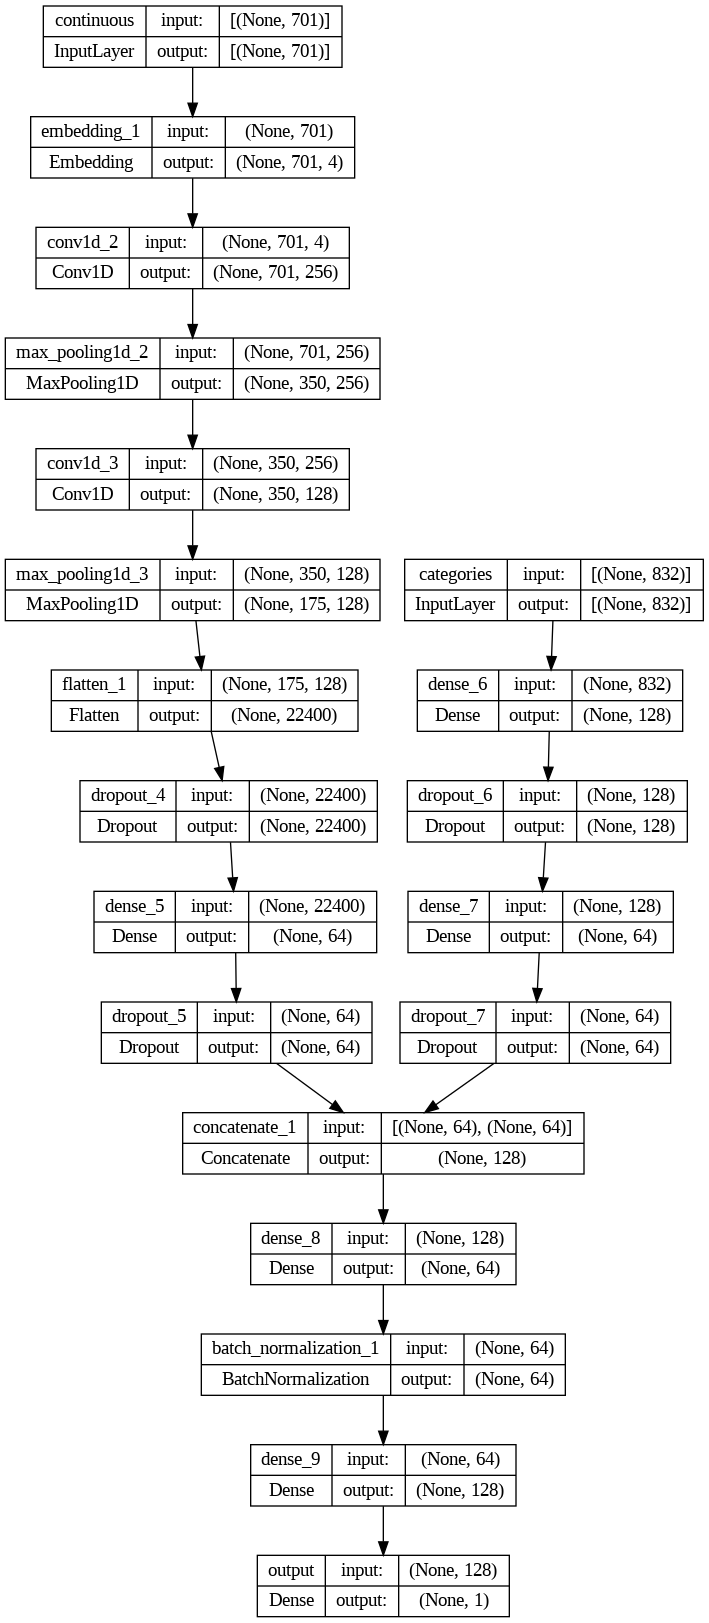

In [15]:
tf.keras.utils.set_random_seed(123)

x1 = X_train[cnt_features].values
x2 = X_train[cat_features].values
y = y_train

def get_model():
    AF = "relu"
    input_1 = keras.layers.Input(shape=(x1.shape[-1]), name="continuous")
    x_1 = keras.layers.Embedding(input_dim=bins, output_dim=4)(input_1)
    x_1 = keras.layers.Conv1D (filters=256, kernel_size=20,padding = 'same', activation = AF)(x_1)
    x_1 = keras.layers.MaxPooling1D()(x_1)
    x_1 = keras.layers.Conv1D (filters=128, kernel_size=10,padding = 'same', activation = AF)(x_1)
    x_1 = keras.layers.MaxPooling1D()(x_1)
    x_1 = keras.layers.Flatten()(x_1)
    #x_1 = keras.layers.Dense(128, activation=AF)(x_1)
    x_1 = keras.layers.Dropout(0.3)(x_1)
    x_1 = keras.layers.Dense(64, activation=AF)(x_1)
    x_1 = keras.layers.Dropout(0.5)(x_1)

    input_2 = keras.layers.Input(shape=x2.shape[-1], name="categories")
    x_2 = keras.layers.Dense(128, activation=AF)(input_2)
    x_2 = keras.layers.Dropout(0.4)(x_2)
    x_2 = keras.layers.Dense(64, activation=AF)(x_2)
    x_2 = keras.layers.Dropout(0.5)(x_2)

    x = keras.layers.Concatenate()([x_1,x_2])
    x = keras.layers.Dense(64, activation=AF)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation=AF)(x)
    output = keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    model = tf.keras.Model([input_1,input_2], output)
    return model


model = get_model()
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["AUC", "accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [16]:
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=4, mode="max", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=4, mode="max", min_lr=0.001, verbose=1)

history = model.fit((x1,x2),
                    y,
                    epochs=25,
                    validation_split=0.2,
                    batch_size=512,
                    validation_batch_size=512,
                    callbacks=[cb_es, cb_lr])

Epoch 1/25
5/5 [==============================] - 5s 253ms/step - loss: 0.7336 - auc: 0.5244 - accuracy: 0.5333 - val_loss: 0.6796 - val_auc: 0.6339 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 2/25
5/5 [==============================] - 1s 165ms/step - loss: 0.6911 - auc: 0.5710 - accuracy: 0.5505 - val_loss: 0.6788 - val_auc: 0.6415 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 3/25
5/5 [==============================] - 1s 165ms/step - loss: 0.6869 - auc: 0.5899 - accuracy: 0.5814 - val_loss: 0.6759 - val_auc: 0.6541 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 4/25
5/5 [==============================] - 1s 143ms/step - loss: 0.6687 - auc: 0.6298 - accuracy: 0.6010 - val_loss: 0.6726 - val_auc: 0.7029 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 5/25
5/5 [==============================] - 1s 145ms/step - loss: 0.6660 - auc: 0.6367 - accuracy: 0.6090 - val_loss: 0.6685 - val_auc: 0.7309 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 6/25
5/5 [==============================] - 1s 164ms/step - loss: 0.6

36/36 [==============================] - 0s 6ms/step
[[384 125]
 [133 484]]
Accuracy 0.7708703374777975


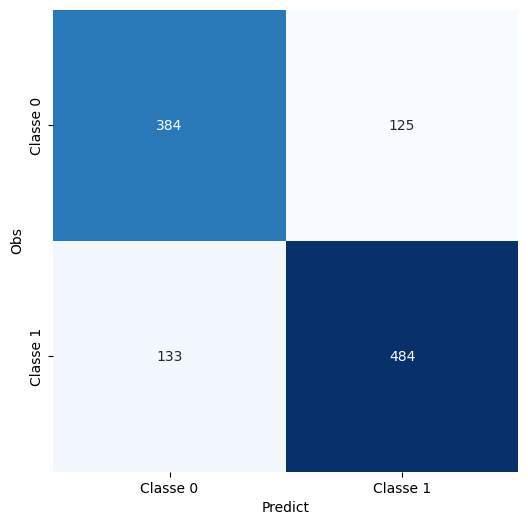

In [17]:
preds = model.predict((X_test[cnt_features].values, X_test[cat_features].values))
y_test_classes = np.where(preds > 0.5,1,0)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_test_classes)
print(cm)
tot = cm[0][0]+cm[1][1] + cm[0][1]+cm[1][0]
accuracy = (cm[0][0]+cm[1][1]) /tot
print("Accuracy", accuracy)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predict')
plt.ylabel('Obs')

plt.show()

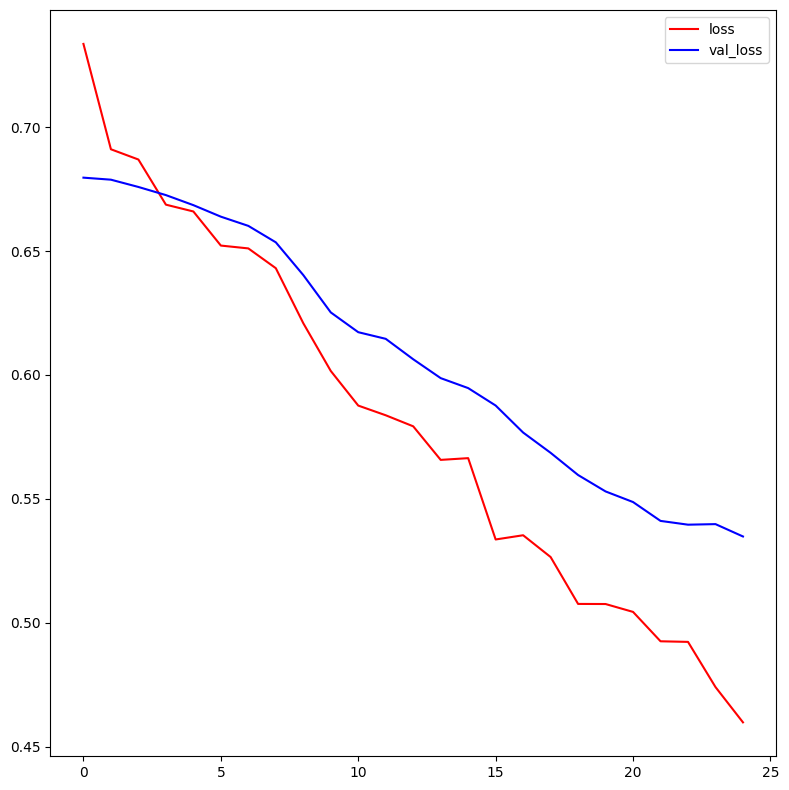

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], color='red', label='loss');
plt.plot(history.history['val_loss'], color='blue', label='val_loss');
plt.legend();
plt.tight_layout();

In [20]:
# Calculate F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_classes)
print("F1-Score:", f1)

# MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_test_classes)
print("MCC:", mcc)

# Sensibilité :
from sklearn.metrics import recall_score
sensitivity = recall_score(y_test, y_test_classes)

print("Sensibilité", sensitivity)

# Calculate Specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Specificity:", specificity)

F1-Score: 0.7895595432300164
MCC: 0.5381762518325366
Sensibilité 0.7844408427876823
Specificity: 0.7544204322200393


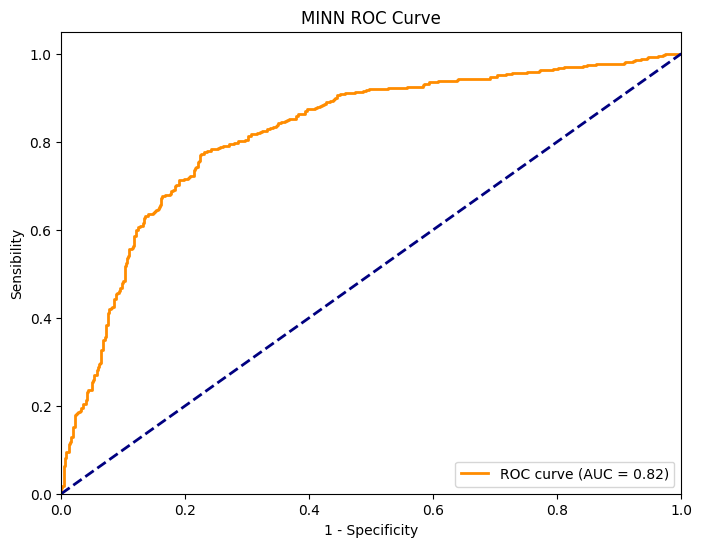

In [21]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensibility')
plt.title('MINN ROC Curve')
plt.legend(loc='lower right')
plt.savefig('Figures/KAGGLE_ROC.png',  dpi=500)
plt.show()

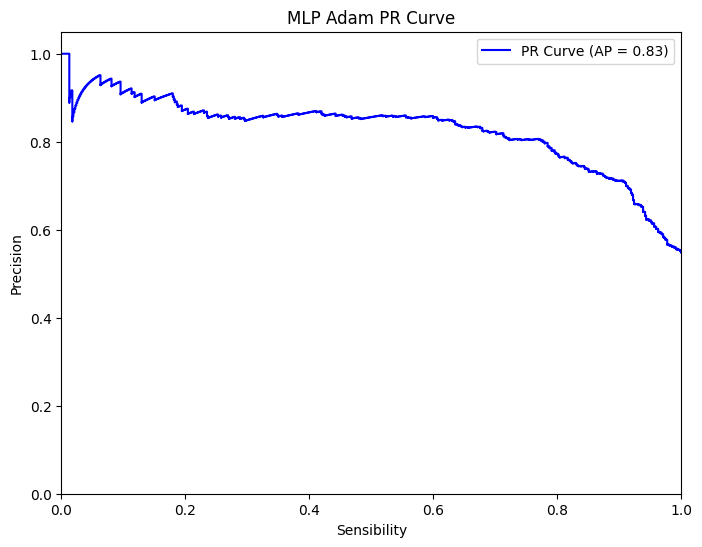

In [22]:
# PR curve :
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_test, preds)

average_precision = average_precision_score(y_test, preds)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Sensibility')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('MLP Adam PR Curve')
plt.legend(loc='upper right')
plt.show()

In [23]:
y_pred_minn_df = pd.DataFrame(preds)
index = y_test.index
y_pred_minn_df = y_pred_minn_df.set_index(index)
y_pred_minn_df.to_csv("YPred_models/MINN.csv", index = True)

Accuracy plots

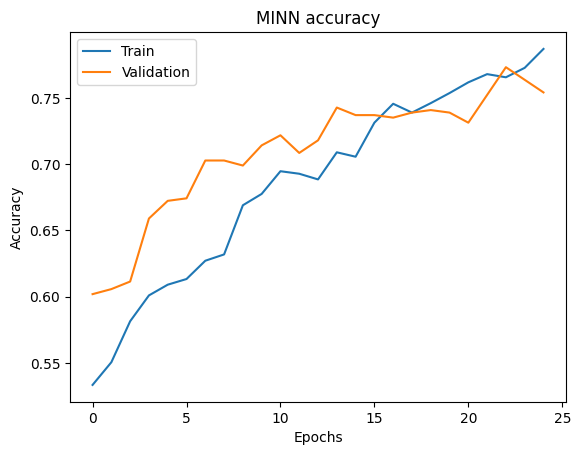

In [26]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MINN accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation', 'Early stopping'], loc='upper left')
plt.savefig('Figures/minn_acc.png',  dpi=500)
plt.show()

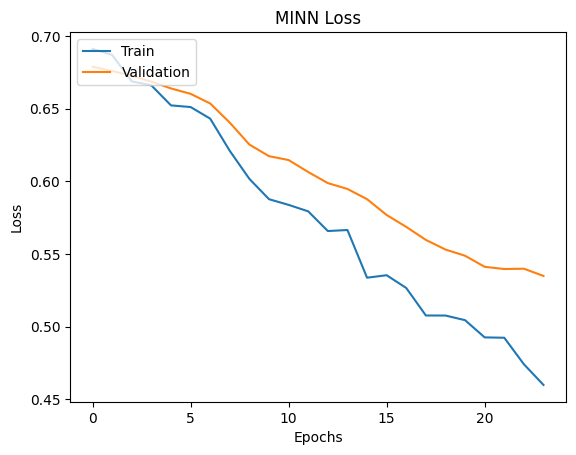

In [28]:
# Curves loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('MINN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation', 'Early stopping'], loc='upper left')
plt.savefig('Figures/minn_loss.png',  dpi=500)
plt.show()

### Soumission Kaggle

In [ ]:
X_scaled = scaler.fit_transform(kaggle_file)
X_scaled = pd.DataFrame(X_scaled, columns = kaggle_file.columns)

preds_kaggle = model.predict((X_scaled[cnt_features].values, kaggle_file[cat_features].values))
y_pred_minn_kaggle_df = pd.DataFrame(preds_kaggle)
y_pred_minn_kaggle_df['moleculeId'] = y_pred_minn_kaggle_df.index
y_pred_minn_kaggle_df['moleculeId'] +=1
column_to_move = y_pred_minn_kaggle_df.pop("moleculeId")
y_pred_minn_kaggle_df.insert(0, "moleculeId", column_to_move)
y_pred_minn_kaggle_df.columns = ["moleculeId","PredictedProbability"]
y_pred_minn_kaggle_df.head(5)
y_pred_minn_kaggle_df.to_csv("YPred_models/MINN_kaggle.csv", index = False)